<img src="imgs/sacramento_kings.png" width="250"/>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import shapiro

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext watermark
%watermark -a "Construção dos Modelos"
%watermark --iversions

Author: Construção dos Modelos

seaborn   : 0.13.2
matplotlib: 3.9.2
scipy     : 1.13.1
sklearn   : 1.6.0
pandas    : 2.2.3
numpy     : 1.26.4



### Funções mais usadas

In [3]:
def limits(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    range_width = q3 - q1
    return q1 - 1.5 * range_width, q3 + 1.5 * range_width

def box_plot(col):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=col, ax=ax1)
    ax2.set_xlim(limits(col))
    sns.boxplot(x=col, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)

# 1) Players

### Dicionário de Dados
- PLAYER_ID: Unique identifier for the player
- PLAYER_NAME: Full name of the player
- GP: Games Played
- PTS_PER_GP: Points per Game
- IMC: Impact Metric Composite (custom or advanced performance metric)
- NET_RATING: Net Rating (points per 100 possessions difference between offensive and defensive rating)
- OREB_PCT: Offensive Rebounding Percentage
- DREB_PCT: Defensive Rebounding Percentage
- USG_PCT: Usage Percentage
- TS_PCT: True Shooting Percentage
- FGM: Field Goals Made
- FGA: Field Goals Attempted
- FG%: Field Goal Percentage
- AST: Assists
- TOV: Turnovers
- PF: Personal Fouls
- TEAM_ABBREVIATION: Team Abbreviation (short code representing the player's team)
- FG_PCT_Restricted_Area: Field Goal Percentage in the Restricted Area
- FG_PCT_In_The_Paint_(Non-RA): Field Goal Percentage in the Paint (Non-Restricted Area)
- FG_PCT_Left_Corner_3: Field Goal Percentage from the Left Corner Three
- FG_PCT_Right_Corner_3: Field Goal Percentage from the Right Corner Three
- FG_PCT_Mid-Range: Field Goal Percentage from Mid-Range
- FG_PCT_Above_the_Break_3: Field Goal Percentage from Above the Break Three
- AST_PER_GP: Assists per Game
- STL_PER_GP: Steals per Game
- BLK_PER_GP: Blocks per Game
- MIN_PER_GP: Minutes Played per Game

## 1.1) Principais Métricas

### 1.1.1) Usage Percentage
Estima a quantidade de posses de bola usadas por um jogador enquanto está em quadra, expressa como uma porcentagem.
Quanto maior, mais influente é o jogador em quadra.

$ \text{Usage Percentage} = \frac{(\text{Field Goals Attempted} + 0.44 \times \text{Free Throws Attempted} + \text{Turnovers})}{\text{Minutes Played} \times \text{Team Total Possession Time}}  \times 100 $

- Field Goals Attempted: O número de arremessos tentados pelo jogador.
- Free Throws Attempted: O número de lances livres tentados pelo jogador.
- Turnovers: O número de vezes que o jogador perde a posse de bola para o time adversário.
- Minutes Played: O tempo total em minutos que o jogador esteve em quadra.
- Team Total Possession Time: O tempo total em minutos que a equipe teve a posse de bola durante o jogo.

### 1.1.2) True Shooting Percentage
O TSP leva em consideração arremessos de campo, lances livres e, em alguns casos, arremessos de três pontos.


Util para comparar jogadores que podem ter estilos de jogo diferentes em termos de arremessos de campo e lances livres.

$ \text{True Shooting Percentage} = \frac{\text{Points Made}}{2 \times (\text{Field Goals Attempted} + 0.44 \times \text{Free Throws Attempted})} \times 100 $

- Points Made: Número total de pontos marcados pelo jogador.
- Field Goals Attempted: Número de arremessos de campo tentados pelo jogador.
- Free Throws Attempted: Número de lances livres tentados pelo jogador.

In [4]:
players = pd.read_csv('datasets/players.csv')
players.drop(columns=['PLAYER_ID'],inplace=True)

In [5]:
players.head()

,PLAYER_NAME,GP,PTS_PER_GP,IMC,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,FGM,...,FG_PCT_Restricted_Area,FG_PCT_In_The_Paint_(Non-RA),FG_PCT_Left_Corner_3,FG_PCT_Right_Corner_3,FG_PCT_Mid-Range,FG_PCT_Above_the_Break_3,AST_PER_GP,STL_PER_GP,BLK_PER_GP,MIN_PER_GP
0,LeBron James,71,25.66,26.72,3.8,2.6,17.2,28.5,63.0,685,...,73.3,41.8,33.3,56.5,32.7,40.6,8.295775,1.253521,0.535211,35.267606
1,Chris Paul,58,9.19,23.70,2.8,1.1,12.6,15.4,54.4,206,...,85.7,52.9,22.7,26.7,44.7,41.1,6.775862,1.206897,0.103448,26.396552
2,Kyle Lowry,60,8.12,26.55,-0.3,2.0,9.8,12.8,59.4,163,...,58.8,46.2,45.5,38.1,45.8,38.3,4.216667,0.983333,0.350000,28.166667
3,P.J. Tucker,31,1.68,28.93,-1.3,5.9,11.6,5.2,50.7,18,...,57.1,0.0,33.3,40.0,50.0,0.0,0.516129,0.516129,0.225806,15.677419
4,Kevin Durant,75,27.09,24.45,4.8,1.6,15.5,28.3,62.6,751,...,77.4,50.2,50.0,44.1,51.8,40.1,5.040000,0.920000,1.213333,37.213333


In [6]:
players.shape

(562, 26)

In [7]:
players.describe()

,GP,PTS_PER_GP,IMC,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,FGM,FGA,...,FG_PCT_Restricted_Area,FG_PCT_In_The_Paint_(Non-RA),FG_PCT_Left_Corner_3,FG_PCT_Right_Corner_3,FG_PCT_Mid-Range,FG_PCT_Above_the_Break_3,AST_PER_GP,STL_PER_GP,BLK_PER_GP,MIN_PER_GP
count,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,...,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000
mean,46.948399,8.558221,24.499840,-2.204448,4.676512,12.981139,17.545552,55.059253,184.580071,389.126335,...,62.761566,38.588790,30.649822,30.426690,34.403025,28.953915,2.030653,0.599058,0.405933,18.932616
std,25.054575,6.771532,1.892823,11.137381,3.629457,5.564322,5.486817,10.152902,185.992548,382.532764,...,16.664009,17.883253,22.248854,22.947933,22.528609,16.473359,1.877299,0.389151,0.411698,9.765238
min,1.000000,0.000000,18.710000,-66.500000,0.000000,0.000000,4.300000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.250000
25%,23.000000,3.570000,23.190000,-7.600000,2.000000,9.300000,13.625000,51.900000,32.250000,72.000000,...,58.225000,33.300000,12.500000,0.000000,21.975000,22.275000,0.737632,0.286654,0.125000,10.973214
50%,52.500000,6.520000,24.505000,-1.000000,3.600000,11.900000,16.600000,56.700000,117.500000,249.000000,...,64.350000,41.450000,33.300000,33.300000,37.500000,33.300000,1.320714,0.554094,0.294118,17.574795
75%,69.000000,11.850000,25.650000,3.700000,6.500000,16.200000,20.775000,60.275000,297.750000,618.000000,...,70.500000,47.550000,44.350000,45.425000,46.700000,38.000000,2.804817,0.856567,0.563077,27.189394
max,84.000000,34.690000,32.860000,50.000000,25.300000,33.100000,41.200000,91.700000,837.000000,1652.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,10.898551,2.050000,3.577465,37.835443


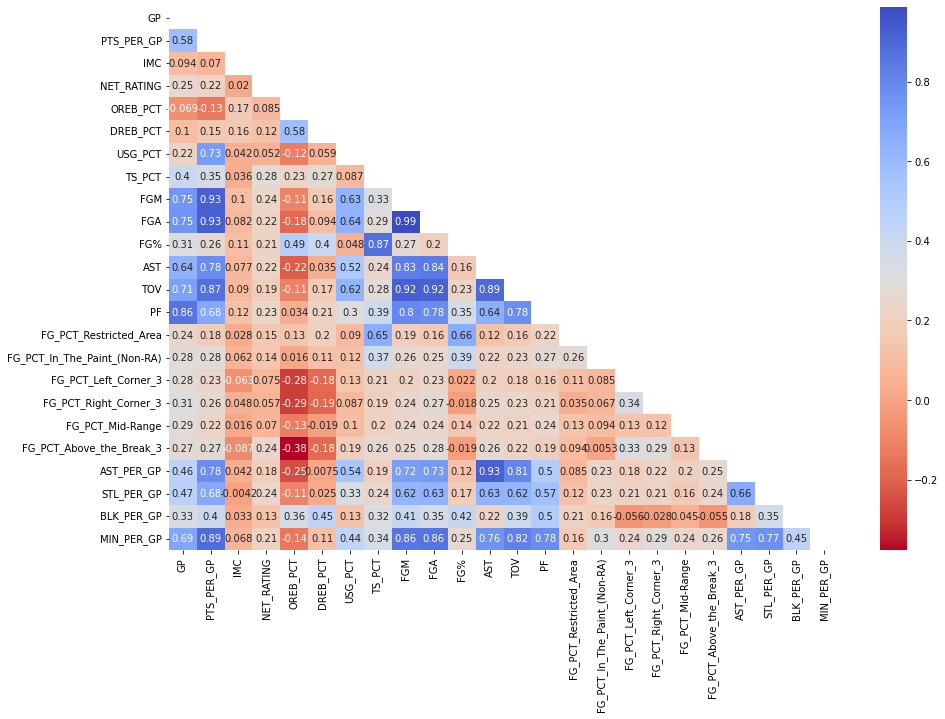

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
corr_matrix = players.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm_r',
            mask=mask,
            ax=ax)
plt.show()

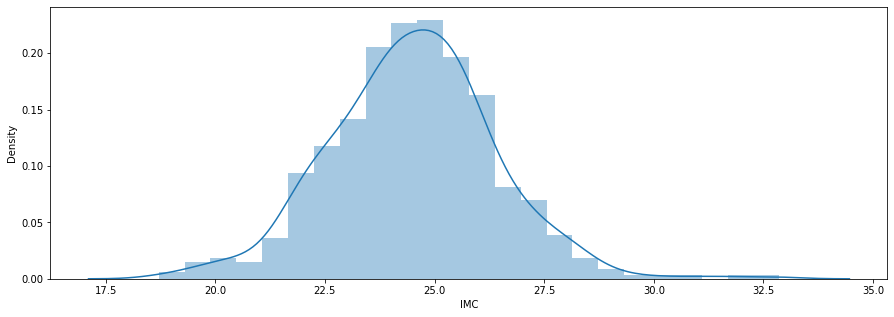

In [9]:
histograma(players['IMC'])

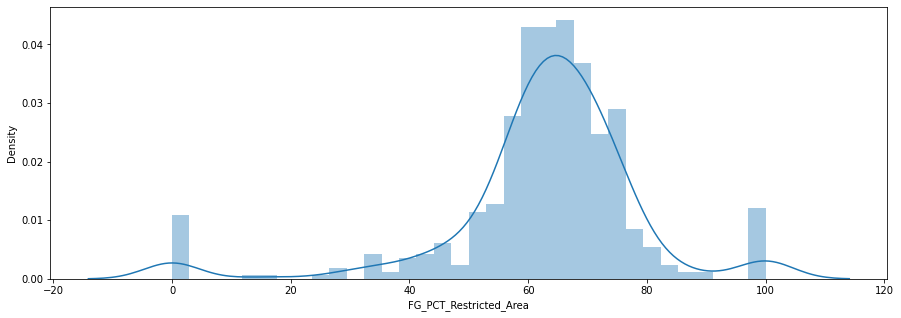

In [10]:
histograma(players['FG_PCT_Restricted_Area'])

In [11]:
players.head(1)

,PLAYER_NAME,GP,PTS_PER_GP,IMC,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,FGM,...,FG_PCT_Restricted_Area,FG_PCT_In_The_Paint_(Non-RA),FG_PCT_Left_Corner_3,FG_PCT_Right_Corner_3,FG_PCT_Mid-Range,FG_PCT_Above_the_Break_3,AST_PER_GP,STL_PER_GP,BLK_PER_GP,MIN_PER_GP
0,LeBron James,71,25.66,26.72,3.8,2.6,17.2,28.5,63.0,685,...,73.3,41.8,33.3,56.5,32.7,40.6,8.295775,1.253521,0.535211,35.267606


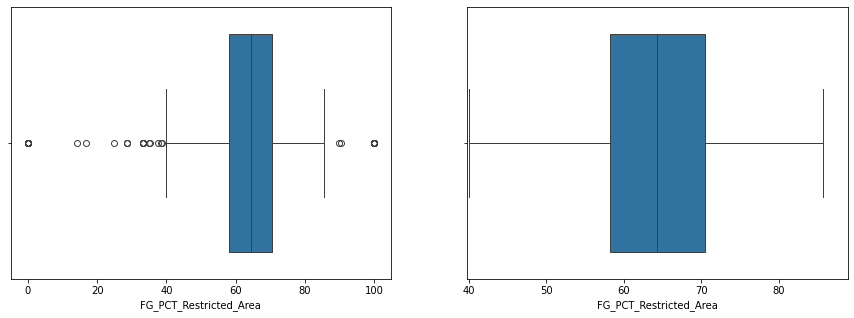

In [12]:
box_plot(players['FG_PCT_Restricted_Area'])

In [14]:
players_grouped = (
    players[['TEAM_ABBREVIATION', "FG_PCT_Restricted_Area"]]
    .groupby('TEAM_ABBREVIATION')
    .median()
    .sort_values(by='FG_PCT_Restricted_Area', ascending=False)
)

In [15]:
players_grouped.head(10)

,FG_PCT_Restricted_Area
TEAM_ABBREVIATION,
BOS,71.10
GSW,70.85
SAC,69.00
UTA,68.65
IND,68.30
DAL,67.70
OKC,67.65
LAC,66.90
ORL,66.90


<Axes: xlabel='TEAM_ABBREVIATION'>

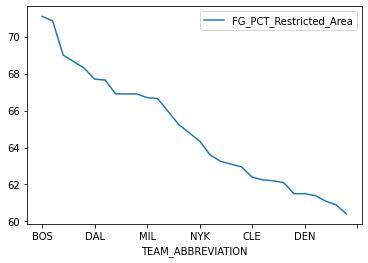

In [16]:
players_grouped.plot()

# 2) Teams

## Dicionário de Dados
- FG%: Field Goal Percentage
- FG_PCT_Restricted_Area_PER_GP: Field Goal Percentage in the Restricted Area per Game
- FG_PCT_In_The_Paint_(Non-RA)_PER_GP: Field Goal Percentage in the Paint (Non-Restricted Area) per Game
- FG_PCT_Left_Corner_3_PER_GP: Field Goal Percentage from Left Corner 3 per Game
- FG_PCT_Right_Corner_3_PER_GP: Field Goal Percentage from Right Corner 3 per Game
- FG_PCT_Mid-Range_PER_GP: Field Goal Percentage from Mid-Range per Game
- FG_PCT_Above_the_Break_3_PER_GP: Field Goal Percentage from Above the Break 3 per Game
- WinPCT: Winning Percentage in the Season
- HOME: Winning Percentage at Home
- ROAD: Winning Percentage Away
- GP: Games Played
- W: Wins
- L: Losses
- TEAM_ID: Team Identifier
- TEAM_NAME: Team Name

In [17]:
teams = pd.read_csv('datasets/teams.csv')

In [18]:
teams.head()

,TEAM_ID,TEAM_NAME,GP,W,L,FG%,FG_PCT_Restricted_Area_PER_GP,FG_PCT_In_The_Paint_(Non-RA)_PER_GP,FG_PCT_Left_Corner_3_PER_GP,FG_PCT_Right_Corner_3_PER_GP,FG_PCT_Mid-Range_PER_GP,FG_PCT_Above_the_Break_3_PER_GP,WinPCT,HOME,ROAD
0,1610612737,Atlanta Hawks,82,36,46,53.9,62.3,44.0,36.0,40.4,46.8,36.0,43.9,51.22,36.59
1,1610612738,Boston Celtics,82,64,18,57.8,70.3,45.4,42.1,43.9,43.1,37.7,78.0,90.24,65.85
2,1610612751,Brooklyn Nets,82,32,50,53.1,64.5,40.7,42.4,39.9,38.6,34.6,39.0,48.78,29.27
3,1610612766,Charlotte Hornets,82,21,61,52.9,65.2,41.7,34.7,37.9,38.2,35.6,25.6,26.83,24.39
4,1610612741,Chicago Bulls,82,39,43,53.4,62.2,46.4,39.3,37.7,43.7,34.9,47.6,48.78,46.34


# Clustering

## Sacramento

In [19]:
players.columns

Index(['PLAYER_NAME', 'GP', 'PTS_PER_GP', 'IMC', 'NET_RATING', 'OREB_PCT',
       'DREB_PCT', 'USG_PCT', 'TS_PCT', 'FGM', 'FGA', 'FG%', 'AST', 'TOV',
       'PF', 'TEAM_ABBREVIATION', 'FG_PCT_Restricted_Area',
       'FG_PCT_In_The_Paint_(Non-RA)', 'FG_PCT_Left_Corner_3',
       'FG_PCT_Right_Corner_3', 'FG_PCT_Mid-Range', 'FG_PCT_Above_the_Break_3',
       'AST_PER_GP', 'STL_PER_GP', 'BLK_PER_GP', 'MIN_PER_GP'],
      dtype='object')

In [20]:
players.head()

,PLAYER_NAME,GP,PTS_PER_GP,IMC,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,FGM,...,FG_PCT_Restricted_Area,FG_PCT_In_The_Paint_(Non-RA),FG_PCT_Left_Corner_3,FG_PCT_Right_Corner_3,FG_PCT_Mid-Range,FG_PCT_Above_the_Break_3,AST_PER_GP,STL_PER_GP,BLK_PER_GP,MIN_PER_GP
0,LeBron James,71,25.66,26.72,3.8,2.6,17.2,28.5,63.0,685,...,73.3,41.8,33.3,56.5,32.7,40.6,8.295775,1.253521,0.535211,35.267606
1,Chris Paul,58,9.19,23.70,2.8,1.1,12.6,15.4,54.4,206,...,85.7,52.9,22.7,26.7,44.7,41.1,6.775862,1.206897,0.103448,26.396552
2,Kyle Lowry,60,8.12,26.55,-0.3,2.0,9.8,12.8,59.4,163,...,58.8,46.2,45.5,38.1,45.8,38.3,4.216667,0.983333,0.350000,28.166667
3,P.J. Tucker,31,1.68,28.93,-1.3,5.9,11.6,5.2,50.7,18,...,57.1,0.0,33.3,40.0,50.0,0.0,0.516129,0.516129,0.225806,15.677419
4,Kevin Durant,75,27.09,24.45,4.8,1.6,15.5,28.3,62.6,751,...,77.4,50.2,50.0,44.1,51.8,40.1,5.040000,0.920000,1.213333,37.213333


In [46]:
# players.columns

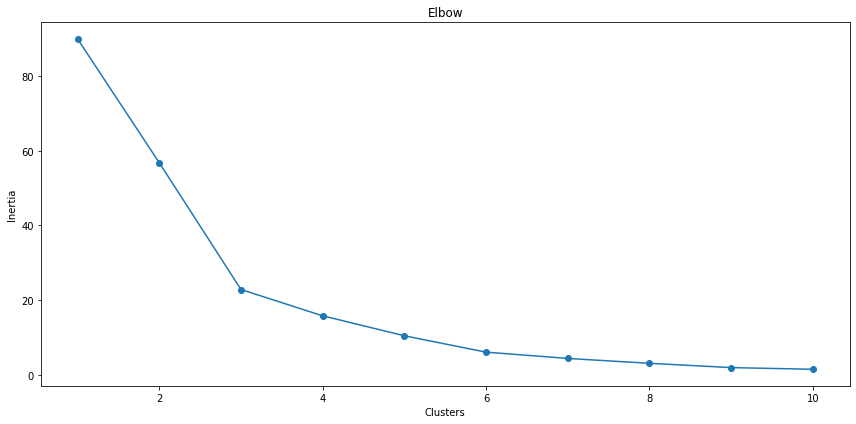

In [21]:
sacramento_players = players[players['TEAM_ABBREVIATION'] == 'SAC']


selected_columns = ['FG_PCT_Restricted_Area', 'FG_PCT_In_The_Paint_(Non-RA)', 'PTS_PER_GP', 'AST_PER_GP', 'STL_PER_GP', 'BLK_PER_GP']

selected_data = sacramento_players[selected_columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertias.append(kmeans.inertia_)


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, 11), inertias, marker='o')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')
ax.set_title('Elbow')


plt.tight_layout()
plt.show()

In [22]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(pca_result)
silhouette_avg = silhouette_score(pca_result, labels)

print(f'Silhouette Score para {num_clusters} clusters: {silhouette_avg}')

Silhouette Score para 3 clusters: 0.4934762844421227


In [23]:
sacramento_players = players[players['TEAM_ABBREVIATION'] == 'SAC']

selected_columns = ['FG_PCT_Restricted_Area', 'FG_PCT_In_The_Paint_(Non-RA)', 'PTS_PER_GP', 'STL_PER_GP', 'BLK_PER_GP']

selected_data = sacramento_players[selected_columns]

scaled_data = scaler.fit_transform(selected_data)

pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled_data)

kmeans = KMeans(n_clusters=3, random_state=42)
sacramento_players['cluster'] = kmeans.fit_predict(pca_result)

In [24]:
sacramento_players['cluster'].value_counts()

cluster
0    13
1     6
2     1
Name: count, dtype: int64

In [25]:
sacramento_players.head()

,PLAYER_NAME,GP,PTS_PER_GP,IMC,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,FGM,...,FG_PCT_In_The_Paint_(Non-RA),FG_PCT_Left_Corner_3,FG_PCT_Right_Corner_3,FG_PCT_Mid-Range,FG_PCT_Above_the_Break_3,AST_PER_GP,STL_PER_GP,BLK_PER_GP,MIN_PER_GP,cluster
16,JaVale McGee,46,4.02,26.99,-1.9,11.5,23.5,21.4,60.9,79,...,44.4,0.0,0.0,20.0,14.3,0.369565,0.304348,0.434783,7.369565,0
54,Harrison Barnes,82,12.20,24.77,-1.7,2.7,7.9,15.4,61.1,347,...,46.9,39.8,42.5,49.0,37.0,1.207317,0.658537,0.146341,29.036585,0
60,Alex Len,48,2.50,25.00,15.4,9.8,17.9,11.4,62.5,50,...,44.4,0.0,0.0,66.7,0.0,1.041667,0.229167,0.687500,9.250000,1
110,Trey Lyles,58,7.22,25.01,7.7,5.2,16.6,13.9,59.6,143,...,42.1,38.3,36.8,16.7,39.7,1.241379,0.293103,0.327586,19.965517,0
123,Domantas Sabonis,82,19.43,25.16,0.8,9.7,29.5,22.0,63.7,634,...,47.8,0.0,33.3,45.8,39.0,8.207317,0.902439,0.585366,35.707317,1


In [26]:
sacramento_players_grouped = (
    sacramento_players[['cluster', "FG_PCT_Restricted_Area"]]
    .groupby('cluster')
    .median()
)

In [27]:
sacramento_players_grouped

,FG_PCT_Restricted_Area
cluster,
0,69.0
1,70.1
2,66.8


In [28]:
sacramento_players

,PLAYER_NAME,GP,PTS_PER_GP,IMC,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,FGM,...,FG_PCT_In_The_Paint_(Non-RA),FG_PCT_Left_Corner_3,FG_PCT_Right_Corner_3,FG_PCT_Mid-Range,FG_PCT_Above_the_Break_3,AST_PER_GP,STL_PER_GP,BLK_PER_GP,MIN_PER_GP,cluster
16,JaVale McGee,46,4.02,26.99,-1.9,11.5,23.5,21.4,60.9,79,...,44.4,0.0,0.0,20.0,14.3,0.369565,0.304348,0.434783,7.369565,0
54,Harrison Barnes,82,12.20,24.77,-1.7,2.7,7.9,15.4,61.1,347,...,46.9,39.8,42.5,49.0,37.0,1.207317,0.658537,0.146341,29.036585,0
60,Alex Len,48,2.50,25.00,15.4,9.8,17.9,11.4,62.5,50,...,44.4,0.0,0.0,66.7,0.0,1.041667,0.229167,0.687500,9.250000,1
110,Trey Lyles,58,7.22,25.01,7.7,5.2,16.6,13.9,59.6,143,...,42.1,38.3,36.8,16.7,39.7,1.241379,0.293103,0.327586,19.965517,0
123,Domantas Sabonis,82,19.43,25.16,0.8,9.7,29.5,22.0,63.7,634,...,47.8,0.0,33.3,45.8,39.0,8.207317,0.902439,0.585366,35.707317,1
148,De'Aaron Fox,74,26.57,23.00,4.3,2.4,10.4,30.0,56.7,720,...,51.2,48.1,32.3,37.1,36.1,5.648649,2.027027,0.418919,35.932432,2
150,Malik Monk,72,15.42,24.87,0.1,1.4,10.1,24.7,56.4,396,...,44.8,32.3,46.9,45.5,34.2,5.138889,0.625000,0.541667,26.000000,1
172,Sasha Vezenkov,42,5.36,24.77,1.3,5.8,12.9,17.1,56.9,84,...,28.0,45.0,38.9,25.0,35.8,0.452381,0.476190,0.166667,12.166667,0
196,Kevin Huerter,64,10.23,22.23,2.5,2.4,12.4,17.3,56.4,248,...,47.1,36.7,50.0,34.4,34.4,2.593750,0.703125,0.359375,24.406250,1
234,Juan Toscano-Anderson,11,0.64,24.18,-0.1,6.8,16.7,10.6,29.2,3,...,0.0,0.0,100.0,0.0,0.0,0.363636,0.090909,0.090909,4.818182,0


## Regressor: previsão de pontos por partida

In [29]:
players_ml = players.dropna()
players_ml.reset_index(drop=True, inplace=True)

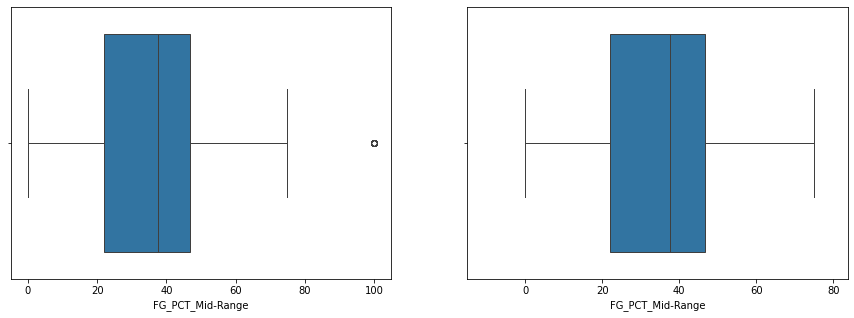

In [30]:
box_plot(players_ml['FG_PCT_Mid-Range'])

In [31]:
def remove_outliers(df, column_name):
    num_rows = df.shape[0]
    lower_limit, upper_limit = limits(df[column_name])
    df = df.loc[(df[column_name] >= lower_limit) & (df[column_name] <= upper_limit), :]
    removed_rows = num_rows - df.shape[0]
    return df, removed_rows

In [32]:
players_ml, removed_rows = remove_outliers(players_ml, 'FG_PCT_Mid-Range')
print(f'Linhas removidas: {removed_rows}')

Linhas removidas: 19


In [33]:
def evaluate_model(model_name, y_test, predictions, cv_scores):
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return f'Model {model_name}:\nR2: {r2:.2%}\nRMSE: {rmse:.2f}\nMean RMSE (cross-validated): {np.sqrt(-cv_scores.mean()):.2f}'

In [49]:
# players_ml.iloc[:3,8:]

,TS_PCT,FGM,FGA,FG%,AST,TOV,PF,TEAM_ABBREVIATION,FG_PCT_Restricted_Area,FG_PCT_In_The_Paint_(Non-RA),FG_PCT_Left_Corner_3,FG_PCT_Right_Corner_3,FG_PCT_Mid-Range,FG_PCT_Above_the_Break_3,AST_PER_GP,STL_PER_GP,BLK_PER_GP,MIN_PER_GP
0,63.0,685,1269,54.0,589,245,78,LAL,73.3,41.8,33.3,56.5,32.7,40.6,8.295775,1.253521,0.535211,35.267606
1,54.4,206,467,44.1,393,76,108,GSW,85.7,52.9,22.7,26.7,44.7,41.1,6.775862,1.206897,0.103448,26.396552
2,59.4,163,377,43.2,253,85,146,PHI,58.8,46.2,45.5,38.1,45.8,38.3,4.216667,0.983333,0.350000,28.166667


In [35]:
players_ml

,PLAYER_NAME,GP,PTS_PER_GP,IMC,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,FGM,...,FG_PCT_Restricted_Area,FG_PCT_In_The_Paint_(Non-RA),FG_PCT_Left_Corner_3,FG_PCT_Right_Corner_3,FG_PCT_Mid-Range,FG_PCT_Above_the_Break_3,AST_PER_GP,STL_PER_GP,BLK_PER_GP,MIN_PER_GP
0,LeBron James,71,25.66,26.72,3.8,2.6,17.2,28.5,63.0,685,...,73.3,41.8,33.3,56.5,32.7,40.6,8.295775,1.253521,0.535211,35.267606
1,Chris Paul,58,9.19,23.70,2.8,1.1,12.6,15.4,54.4,206,...,85.7,52.9,22.7,26.7,44.7,41.1,6.775862,1.206897,0.103448,26.396552
2,Kyle Lowry,60,8.12,26.55,-0.3,2.0,9.8,12.8,59.4,163,...,58.8,46.2,45.5,38.1,45.8,38.3,4.216667,0.983333,0.350000,28.166667
3,P.J. Tucker,31,1.68,28.93,-1.3,5.9,11.6,5.2,50.7,18,...,57.1,0.0,33.3,40.0,50.0,0.0,0.516129,0.516129,0.225806,15.677419
4,Kevin Durant,75,27.09,24.45,4.8,1.6,15.5,28.3,62.6,751,...,77.4,50.2,50.0,44.1,51.8,40.1,5.040000,0.920000,1.213333,37.213333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,Dexter Dennis,4,5.50,24.79,-11.0,2.5,21.1,27.8,54.1,10,...,100.0,100.0,0.0,0.0,33.3,12.5,1.000000,0.000000,0.250000,7.500000
558,Onuralp Bitim,23,3.48,24.88,-8.5,2.2,9.6,14.9,46.4,32,...,63.2,33.3,20.0,40.0,44.4,27.6,0.565217,0.130435,0.086957,11.652174
559,Maozinha Pereira,7,6.86,19.48,2.7,7.7,20.6,14.3,60.9,18,...,66.7,25.0,50.0,50.0,0.0,33.3,0.285714,0.857143,0.571429,17.428571
560,Trey Jemison III,25,6.84,27.26,-7.3,10.5,13.1,13.2,58.2,75,...,63.2,47.4,0.0,0.0,18.2,0.0,1.080000,0.480000,1.120000,22.960000


In [36]:
model_rf = RandomForestRegressor()
model_lr = LinearRegression()
model_et = ExtraTreesRegressor()

models = {'RandomForest': model_rf,
          'LinearRegression': model_lr,
          'ExtraTrees': model_et}

y = players_ml['PTS_PER_GP']
X = players_ml.drop(columns=['PTS_PER_GP',
                             'PLAYER_NAME',
                             'TEAM_ABBREVIATION',
                             'IMC'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    predictions = model.predict(X_test)

    print(evaluate_model(model_name, y_test, predictions, cv_scores))
    print()

Model RandomForest:
R2: 97.45%
RMSE: 0.96
Mean RMSE (cross-validated): 1.19

Model LinearRegression:
R2: 96.29%
RMSE: 1.16
Mean RMSE (cross-validated): 1.09

Model ExtraTrees:
R2: 98.39%
RMSE: 0.76
Mean RMSE (cross-validated): 1.15



,0
MIN_PER_GP,0.338599
FGM,0.239244
FGA,0.207879
USG_PCT,0.089184
TOV,0.055092
AST_PER_GP,0.016028
AST,0.015996
GP,0.011160
TS_PCT,0.004103
STL_PER_GP,0.003135


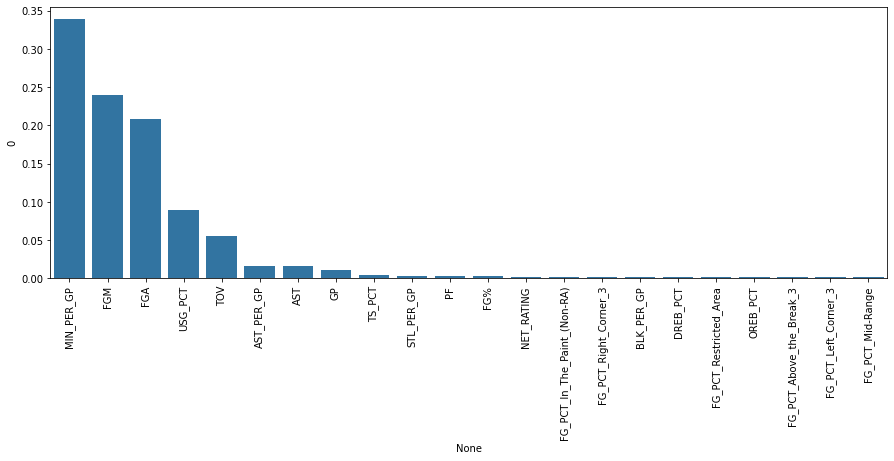

In [37]:
feature_importance = pd.DataFrame(model_et.feature_importances_, X_train.columns)
feature_importance = feature_importance.sort_values(by=0, ascending=False)
display(feature_importance)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=feature_importance.index, y=feature_importance[0])
ax.tick_params(axis='x', rotation=90)

## Residual

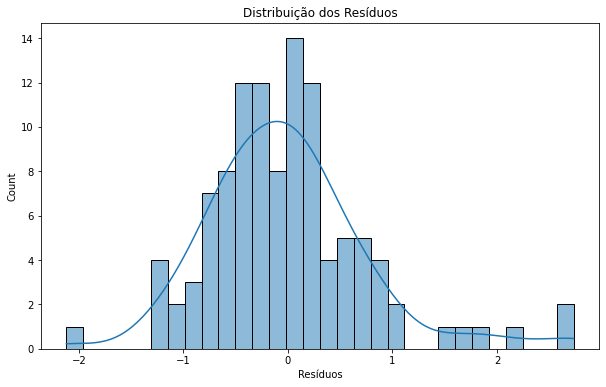

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test - predictions, bins=30, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.show()

In [39]:
# Cálculo dos resíduos
residuals = y_test - predictions

# Teste de Shapiro-Wilk
stat, p_value = shapiro(residuals)

print(f'Teste de Shapiro-Wilk:\nStatistic: {stat:.4f}, p-value: {p_value:.4f}')

# Interpretação do resultado
alpha = 0.05  # nível de significância
if p_value > alpha:
    print("Não podemos rejeitar a hipótese nula. Os resíduos parecem seguir uma distribuição normal com valor de significância de 95%.")
else:
    print("Rejeitamos a hipótese nula. Os resíduos não seguem uma distribuição normal.")

Teste de Shapiro-Wilk:
Statistic: 0.9370, p-value: 0.0001
Rejeitamos a hipótese nula. Os resíduos não seguem uma distribuição normal.


### Função do plot da quadra para os jogadores

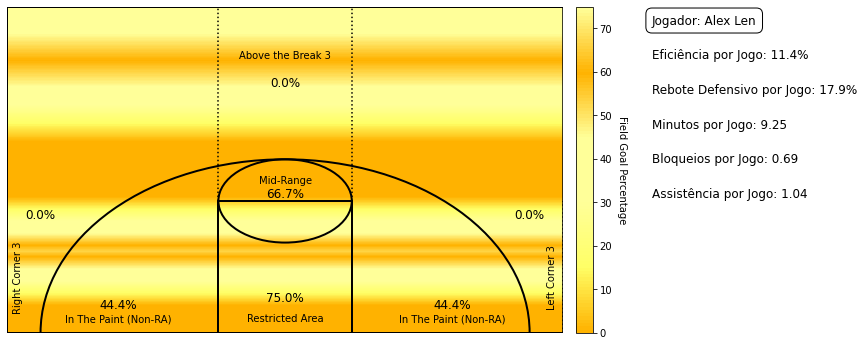

In [40]:
def adjust_color_intensity(value):
    if value < 30:
        # Amarelo mais claro
        return (1, 1, 0.6)
    elif 30 <= value < 45:
        # Laranja claro
        return (1, 1, 0.4)
    elif 45 <= value < 60:
        # Laranja médio
        return (1, 0.9, 0.2)
    else:
        # Laranja escuro
        return (1, 0.7, 0)



def draw_court(df, name):
    # Probabilidades do Dataframe   
    df = df.loc[df['PLAYER_NAME'] == name]
    player_card_text = f"Jogador: {name}"
    
    restricted_area_pct = df['FG_PCT_Restricea']ted_Ar.iloc[0]
    restricted_area_text = f'{restricted_area_pct:.1f}%'

    in_the_paint_pct = df['FG_PCT_In_The_Paint_(Non-RA)'].iloc[0]
    in_the_paint_pct_text = f'{in_the_paint_pct:.1f}%'

    left_corner_pct = df['FG_PCT_Left_Corner_3'].iloc[0]
    left_corner_pct_text = f'{left_corner_pct:.1f}%'

    right_corner_pct = df['FG_PCT_Right_Corner_3'].iloc[0]
    right_corner_pct_text = f'{right_corner_pct:.1f}%'

    mid_range_pct = df['FG_PCT_Mid-Range'].iloc[0]
    mid_range_pct_text = f'{mid_range_pct:.1f}%'

    above_break_3_pct = df['FG_PCT_Above_the_Break_3'].iloc[0]
    above_break_3_pct_text = f'{above_break_3_pct:.1f}%'     

    cmap_name = 'light_to_dark'
    n_bins = 100
    
    # Criar uma figura e eixo
    fig, ax = plt.subplots(figsize=(12, 6))

    # Adicionar retângulo externo da quadra
    outer_box = patches.Rectangle((0, 0), 60, 47, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(outer_box)

    # Adicionar arco de três pontos
    three_point_arc = patches.Arc((25, 0), 44, 50, theta1=0, theta2=180, linewidth=2, edgecolor='black')
    ax.add_patch(three_point_arc)   

    # Adicionar círculo do garrafão
    paint_circle = patches.Circle((25, 19), radius=6, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(paint_circle)

    # Adicionar retângulo da área restrita
    restricted_area = patches.Rectangle((19, 0), 12, 19, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(restricted_area)

    # Adicionar heatmap na área restrita
#     heatmap_data = np.array([[restricted_area_pct]])
    heatmap_data = np.array([
        [restricted_area_pct],
        [in_the_paint_pct],
        [left_corner_pct],
        [right_corner_pct],
        [mid_range_pct],
        [above_break_3_pct]
    ])
    adjusted_colors = [adjust_color_intensity(value) for value in heatmap_data.flatten()]      
    cmap = LinearSegmentedColormap.from_list(cmap_name, adjusted_colors, N=n_bins)
    
    heatmap = ax.imshow(heatmap_data, cmap=cmap, interpolation='bilinear', aspect='auto', extent=(0, 50, 0, 47))

    # Adicionar barra de cores
    cbar = plt.colorbar(heatmap, ax=ax, pad=0.02)
    cbar.set_label('Field Goal Percentage', rotation=270, labelpad=15)

    # Adicionar linhas laterais
    ax.plot([0, 0], [0, 47], color='black')
    ax.plot([50, 50], [0, 47], color='black')

    # Adicionar texto indicando as zonas
    ax.text(3, 17, right_corner_pct_text, fontsize=12, ha='center', va='center')
    ax.text(1, 8, 'Right Corner 3', fontsize=10, ha='center', va='center', rotation='vertical')    
    
    ax.text(25, 36, above_break_3_pct_text, fontsize=12, ha='center', va='center')
    ax.text(25, 40, 'Above the Break 3', fontsize=10, ha='center', va='center')    
    
    ax.text(47, 17, left_corner_pct_text, fontsize=12, ha='center', va='center')
    ax.text(49, 8, 'Left Corner 3', fontsize=10, ha='center', va='center', rotation='vertical')
    
    ax.text(10, 4, in_the_paint_pct_text, fontsize=12, ha='center', va='center')
    ax.text(10, 2, 'In The Paint (Non-RA)', fontsize=10, ha='center', va='center')
    
    ax.text(40, 4, in_the_paint_pct_text, fontsize=12, ha='center', va='center')
    ax.text(40, 2, 'In The Paint (Non-RA)', fontsize=10, ha='center', va='center')   
    
    ax.text(25, 5, restricted_area_text, fontsize=12, ha='center', va='center')
    ax.text(25, 2, 'Restricted Area', fontsize=10, ha='center', va='center')   
    
    ax.text(25, 20, mid_range_pct_text, fontsize=12, ha='center', va='center')
    ax.text(25, 22, 'Mid-Range', fontsize=10, ha='center', va='center')    
    
    ax.text(58, 45, player_card_text, fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
       
    
    # Outras variáveis do card
    usg_pct = f"Eficiência por Jogo: {round(df['USG_PCT'].iloc[0], 2)}%"
    dreb_pct = f"Rebote Defensivo por Jogo: {round(df['DREB_PCT'].iloc[0], 2)}%"
    min_per_gp = f"Minutos por Jogo: {round(df['MIN_PER_GP'].iloc[0], 2)}"
    blk_per_gp = f"Bloqueios por Jogo: {round(df['BLK_PER_GP'].iloc[0], 2)}"
    ast_pct_per_gp = f"Assistência por Jogo: {round(df['AST_PER_GP'].iloc[0], 2)}"
    
    ax.text(58, 40, usg_pct, fontsize=12, ha='left', va='center')
    ax.text(58, 35, dreb_pct, fontsize=12, ha='left', va='center')
    ax.text(58, 30, min_per_gp, fontsize=12, ha='left', va='center')
    ax.text(58, 25, blk_per_gp, fontsize=12, ha='left', va='center')
    ax.text(58, 20, ast_pct_per_gp, fontsize=12, ha='left', va='center')

    # Adicionar linhas pontilhadas para demarcar as zonas
    ax.plot([0, 0], [0, 19], color='black', linestyle='dotted')
    ax.plot([50, 50], [0, 19], color='black', linestyle='dotted')
    ax.plot([19, 19], [19, 47], color='black', linestyle='dotted')
    ax.plot([31, 31], [19, 47], color='black', linestyle='dotted')

    # Definir limites do eixo
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 47)

    # Desativar eixos
    ax.set_axis_off()

    # Exibir a quadra
    plt.show()
    
draw_court(players, 'Alex Len')

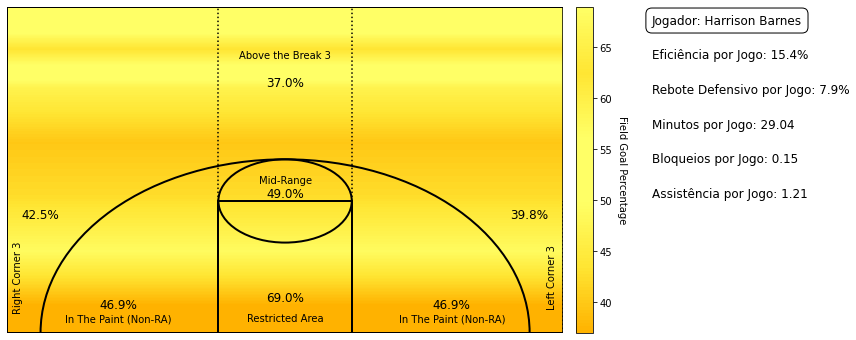

In [41]:
draw_court(players, 'Harrison Barnes')

### Função do plot da quadra para o time

In [50]:
teams.head()

,TEAM_ID,TEAM_NAME,GP,W,L,FG%,FG_PCT_Restricted_Area_PER_GP,FG_PCT_In_The_Paint_(Non-RA)_PER_GP,FG_PCT_Left_Corner_3_PER_GP,FG_PCT_Right_Corner_3_PER_GP,FG_PCT_Mid-Range_PER_GP,FG_PCT_Above_the_Break_3_PER_GP,WinPCT,HOME,ROAD
0,1610612737,Atlanta Hawks,82,36,46,53.9,62.3,44.0,36.0,40.4,46.8,36.0,43.9,51.22,36.59
1,1610612738,Boston Celtics,82,64,18,57.8,70.3,45.4,42.1,43.9,43.1,37.7,78.0,90.24,65.85
2,1610612751,Brooklyn Nets,82,32,50,53.1,64.5,40.7,42.4,39.9,38.6,34.6,39.0,48.78,29.27
3,1610612766,Charlotte Hornets,82,21,61,52.9,65.2,41.7,34.7,37.9,38.2,35.6,25.6,26.83,24.39
4,1610612741,Chicago Bulls,82,39,43,53.4,62.2,46.4,39.3,37.7,43.7,34.9,47.6,48.78,46.34


In [43]:
def draw_court_team(df, name):
    # Probabilidades do Dataframe   
    df = df.loc[df['TEAM_NAME'] == name]
    team_card_text = f"Time: {name}"
    restricted_area_pct = df['FG_PCT_Restricted_Area_PER_GP'].iloc[0]
    restricted_area_text = f'{restricted_area_pct:.1f}%'

    in_the_paint_pct = df['FG_PCT_In_The_Paint_(Non-RA)_PER_GP'].iloc[0]
    in_the_paint_pct_text = f'{in_the_paint_pct:.1f}%'

    left_corner_pct = df['FG_PCT_Left_Corner_3_PER_GP'].iloc[0]
    left_corner_pct_text = f'{left_corner_pct:.1f}%'

    right_corner_pct = df['FG_PCT_Right_Corner_3_PER_GP'].iloc[0]
    right_corner_pct_text = f'{right_corner_pct:.1f}%'

    mid_range_pct = df['FG_PCT_Mid-Range_PER_GP'].iloc[0]
    mid_range_pct_text = f'{mid_range_pct:.1f}%'

    above_break_3_pct = df['FG_PCT_Above_the_Break_3_PER_GP'].iloc[0]
    above_break_3_pct_text = f'{above_break_3_pct:.1f}%'     

    cmap_name = 'light_to_dark'
    n_bins = 100
    
    # Criar uma figura e eixo
    fig, ax = plt.subplots(figsize=(12, 6))

    # Adicionar retângulo externo da quadra
    outer_box = patches.Rectangle((0, 0), 60, 47, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(outer_box)

    # Adicionar arco de três pontos
    three_point_arc = patches.Arc((25, 0), 44, 50, theta1=0, theta2=180, linewidth=2, edgecolor='black')
    ax.add_patch(three_point_arc)   

    # Adicionar círculo do garrafão
    paint_circle = patches.Circle((25, 19), radius=6, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(paint_circle)

    # Adicionar retângulo da área restrita
    restricted_area = patches.Rectangle((19, 0), 12, 19, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(restricted_area)

    # Adicionar heatmap na área restrita
#     heatmap_data = np.array([[restricted_area_pct]])
    heatmap_data = np.array([
        [restricted_area_pct],
        [in_the_paint_pct],
        [left_corner_pct],
        [right_corner_pct],
        [mid_range_pct],
        [above_break_3_pct]
    ])
    adjusted_colors = [adjust_color_intensity(value) for value in heatmap_data.flatten()]      
    cmap = LinearSegmentedColormap.from_list(cmap_name, adjusted_colors, N=n_bins)
    
    heatmap = ax.imshow(heatmap_data, cmap=cmap, interpolation='bilinear', aspect='auto', extent=(0, 50, 0, 47))

    # Adicionar barra de cores
    cbar = plt.colorbar(heatmap, ax=ax, pad=0.02)
    cbar.set_label('Field Goal Percentage', rotation=270, labelpad=15)

    # Adicionar linhas laterais
    ax.plot([0, 0], [0, 47], color='black')
    ax.plot([50, 50], [0, 47], color='black')

    # Adicionar texto indicando as zonas
    ax.text(3, 17, right_corner_pct_text, fontsize=12, ha='center', va='center')
    ax.text(1, 8, 'Right Corner 3', fontsize=10, ha='center', va='center', rotation='vertical')    
    
    ax.text(25, 36, above_break_3_pct_text, fontsize=12, ha='center', va='center')
    ax.text(25, 40, 'Above the Break 3', fontsize=10, ha='center', va='center')    
    
    ax.text(47, 17, left_corner_pct_text, fontsize=12, ha='center', va='center')
    ax.text(49, 8, 'Left Corner 3', fontsize=10, ha='center', va='center', rotation='vertical')
    
    ax.text(10, 4, in_the_paint_pct_text, fontsize=12, ha='center', va='center')
    ax.text(10, 2, 'In The Paint (Non-RA)', fontsize=10, ha='center', va='center')
    
    ax.text(40, 4, in_the_paint_pct_text, fontsize=12, ha='center', va='center')
    ax.text(40, 2, 'In The Paint (Non-RA)', fontsize=10, ha='center', va='center')   
    
    ax.text(25, 5, restricted_area_text, fontsize=12, ha='center', va='center')
    ax.text(25, 2, 'Restricted Area', fontsize=10, ha='center', va='center')   
    
    ax.text(25, 20, mid_range_pct_text, fontsize=12, ha='center', va='center')
    ax.text(25, 22, 'Mid-Range', fontsize=10, ha='center', va='center')    
    
    ax.text(58, 45, team_card_text, fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
       
    
    # Outras variáveis do card
    win_pct = f"Percentual de Vitória: {df['WinPCT'].iloc[0]}%"
    home = f"Jogando em Casa: {df['HOME'].iloc[0]}%"    
    road = f"Jogando Fora: {df['ROAD'].iloc[0]}"

    
    ax.text(58, 40, win_pct, fontsize=12, ha='left', va='center')
    ax.text(58, 35, home, fontsize=12, ha='left', va='center')
    ax.text(58, 30, road, fontsize=12, ha='left', va='center')
 

    # Adicionar linhas pontilhadas para demarcar as zonas
    ax.plot([0, 0], [0, 19], color='black', linestyle='dotted')
    ax.plot([50, 50], [0, 19], color='black', linestyle='dotted')
    ax.plot([19, 19], [19, 47], color='black', linestyle='dotted')
    ax.plot([31, 31], [19, 47], color='black', linestyle='dotted')

    # Definir limites do eixo
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 47)

    # Desativar eixos
    ax.set_axis_off()

    # Exibir a quadra
    plt.show()    

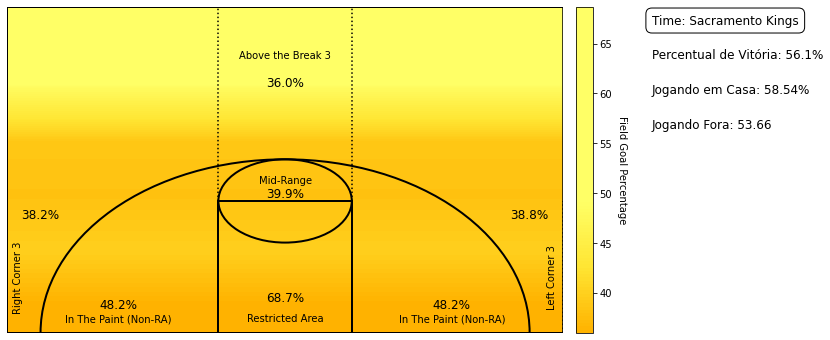

In [44]:
draw_court_team(teams, 'Sacramento Kings')